# LeNet 5

En este Notebook se va a implementar la red convolucional **LeNet 5** en el dataset de nubes creado anteriormente.

In [1]:
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from print_confusion_matrix import print_confusion_matrix

import numpy as np
import pandas as pd
import sklearn.utils
import matplotlib.pyplot as plt

%matplotlib inline

## Formatear el dataset
Primero cargamos los datos desde el disco

In [2]:
cloud_pd = joblib.load('data/clouds.pkl')

Se cuentan los datos que tenemos por cada clase para ver la cantidad que hay de cada uno.

In [3]:
cloud_pd.groupby(by='cloud_type').cloud_type.count()

cloud_type
altocumulos        1729
altostratos        1727
cirros              660
estratocumulos     1743
sky               14109
Name: cloud_type, dtype: int64

Hay pocos datos de cirros, por lo que sería necesario aumentar el numero de datos de esta clase creando imagenes sinteticas de las disponibles. Ademas hay un gran numero de muestras de la clase **sky** con respecto a las demas.

En la siguiente celda se borra esta clase, pues no tiene mucho sentido introducirla en la clasificación. Pues es facilmente diferenciable con el preprocesado que se hizo con los patches en el notebook anterior.

In [4]:
cloud_pd = cloud_pd[cloud_pd.cloud_type != 'sky']

Hacemos data augmentation utilizando **flip** y **rotacion**

In [5]:
from imutils import augmentation
import random

cirros_pd = cloud_pd[cloud_pd.cloud_type == 'cirros']
cirros = cirros_pd.iloc[:, 2:].values
cirros_date = cirros_pd.datestr
cirros = cirros.reshape((-1, 32, 32, 3)).astype(np.uint8)

cirros_pd = pd.DataFrame(columns=['cloud_type', 'datestr', *range(32*32*3)])
row = pd.Series(['cirros', 'datestr', *np.random.rand(32*32*3)],
                index=['cloud_type', 'datestr', *range(32*32*3)])
for (d, c) in zip(cirros_date, cirros):
    row.datestr = d
    
    row[2:] = augmentation.flip_img(c, random.randint(0,1)).flatten()
    cirros_pd = cirros_pd.append(row, ignore_index=True)
    
    row[2:] = augmentation.rot90_img(c, random.randint(0,1)).flatten()
    cirros_pd = cirros_pd.append(row, ignore_index=True)

print(cirros_pd.shape)

(1320, 3074)


In [6]:
cloud_pd = cloud_pd.append(cirros_pd)
cloud_pd = sklearn.utils.shuffle(cloud_pd)

cloud_pd.groupby(by='cloud_type').cloud_type.count()

cloud_type
altocumulos       1729
altostratos       1727
cirros            1980
estratocumulos    1743
Name: cloud_type, dtype: int64

Crear una lookup_table con las etiquetas de las nubes y generar sus indices para el dataset.

In [7]:
cloud_lookup_table, cloud_pd.cloud_type = np.unique(cloud_pd.cloud_type.values,
                                                    return_inverse=True)

print('- Clouds Lookup-table: ', cloud_lookup_table)

- Clouds Lookup-table:  ['altocumulos' 'altostratos' 'cirros' 'estratocumulos']


Dividimos el dataset en sets de train y test.

In [8]:
batchsize = 32
nData = cloud_pd.shape[0]
nData_training = int(nData * 2/3)

# Batches number for training
batches = int(nData_training / batchsize)
nData_training = batches * batchsize
nData_testing = nData - nData_training

print('- Number Data training: {}'.format(nData_training))
print('- Number batches: {}'.format(batches))
print('- Number Data testing: {}'.format(nData_testing))

- Number Data training: 4768
- Number batches: 149
- Number Data testing: 2411


In [9]:
cloud_x = cloud_pd.iloc[:nData_training, 2:]
cloud_y = cloud_pd.iloc[:nData_training, 0]

cloud_test_x = cloud_pd.iloc[nData_training:, 2:]
cloud_test_y = cloud_pd.iloc[nData_training:, 0]

Veamos como estan distribuidos los datos en el set de training

In [10]:
cloud_pd.iloc[:nData_training].groupby(by='cloud_type').cloud_type.count()

cloud_type
0    1147
1    1156
2    1310
3    1155
Name: cloud_type, dtype: int64

Importar paquetes necesarios de **pyTorch** y convertir los datos a tensores.

In [11]:
from torch.autograd import Variable

import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# Training
cloud_x = cloud_x.values.reshape((batches, batchsize, 
                                  32, 32, 3)).astype('uint8')
cloud_x = np.transpose(cloud_x, axes=(0, 1, 4, 2, 3))

cloud_y = cloud_y.values.reshape((batches, batchsize))

# Testing
cloud_test_x = cloud_test_x.values.reshape((cloud_test_x.shape[0],
                                            32, 32, 3)).astype('uint8')
cloud_test_x = np.transpose(cloud_test_x, axes=(0, 3, 1, 2))

cloud_test_y = cloud_test_y.values

# Convert to tensors
cloud_x = Variable(torch.Tensor(cloud_x).contiguous().cuda())
cloud_y = Variable(torch.LongTensor(cloud_y).contiguous().cuda())
cloud_test_x = Variable(torch.Tensor(cloud_test_x).contiguous().cuda())

print('- Cloud_x {}'.format(cloud_x.shape))
print('- Cloud_y {}'.format(cloud_y.shape))
print('- Cloud_test_x {}'.format(cloud_test_x.shape))
print('- Cloud_test_y {}'.format(cloud_test_y.shape))

- Cloud_x torch.Size([149, 32, 3, 32, 32])
- Cloud_y torch.Size([149, 32])
- Cloud_test_x torch.Size([2411, 3, 32, 32])
- Cloud_test_y (2411,)


En este paso se normaliza el dataset

In [13]:
cloud_x = F.normalize(cloud_x, dim=2)
cloud_test_x = F.normalize(cloud_test_x, dim=1)

## Definir la red neuronal

A partir de este punto, se va a definir la arquitecture de **LeNet-5**. Tal y como se muestra en la imagen de abajo, la red esta formada por 2 capas de convolución con un filtro de tamaño (5x5) seguidas de maxpooling (2,2) y 3 capas ocultas fully connected al final.

![Architecture of LeNet-5](https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig3/AS:552880910618630@1508828489678/Architecture-of-LeNet-5.ppm)

In [62]:
class LeNet(nn.Module):
    
    def __init__(self, batch_norm=False):
        super(LeNet, self).__init__()
        self.batch_norm = batch_norm
        
        # First convolutional layer, 6 channels, kernel 5x5
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        
        # Second convolutional layer, 16 channels, kernel 5x5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        
        # Dropout 0.5
        self.drop = nn.Dropout(0.3)
        
        # Fully connected
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(cloud_lookup_table))
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        b_size = x.size(0)

        # 1 Layer
        x = self.drop(self.conv1(x))
        if self.batch_norm:
            x = self.bn1(x)
        x = F.max_pool2d(F.relu(x), (2, 2))
        
        # 2 Layer
        x = self.drop(self.conv2(x))
        if self.batch_norm:
            x = self.bn2(x)
        x = F.max_pool2d(F.relu(x), (2, 2))
        
        # Fully connected
        x = x.view(b_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x)
        
net = LeNet().cuda()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [63]:
import time

def train(e):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00001)
    loss_function = F.nll_loss
    success_history = list()

    start = time.time()

    for epoch in range(e):
        net.train()

        # Training
        for idx in range(cloud_x.shape[0]):
            batch = cloud_x[idx]
            target = cloud_y[idx]
            optimizer.zero_grad() # set to zero gradient buffers
            output = net.forward(batch)
            loss = loss_function(output, target)
            loss.backward() # compute gradients
            optimizer.step() # do the update

        # Testing  
        net.eval()

        output_test = np.argmax(net(cloud_test_x).data.cpu().numpy(), axis=1)
        success = (cloud_test_y == output_test)
        success_history.append(success.sum() / success.shape[0])

        print('[Epoch {}] Train loss: {} Test accuracy: {}'.format(epoch, loss, success_history[epoch]))

    end = time.time()
    print('\n- Time: ', end - start)
    return output_test, success_history

In [64]:
output_test, success_history = train(1000)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 0] Train loss: 1.4223697185516357 Test accuracy: 0.2824554126918291
[Epoch 1] Train loss: 1.4325778484344482 Test accuracy: 0.28287017834923267
[Epoch 2] Train loss: 1.4357672929763794 Test accuracy: 0.2878473662380755
[Epoch 3] Train loss: 1.4402339458465576 Test accuracy: 0.30070510161758607
[Epoch 4] Train loss: 1.432976484298706 Test accuracy: 0.33678971381169637
[Epoch 5] Train loss: 1.439016342163086 Test accuracy: 0.3388635420987142
[Epoch 6] Train loss: 1.4409719705581665 Test accuracy: 0.3463293239319784
[Epoch 7] Train loss: 1.4504207372665405 Test accuracy: 0.3434259643301535
[Epoch 8] Train loss: 1.4403389692306519 Test accuracy: 0.3471588552467856
[Epoch 9] Train loss: 1.4457134008407593 Test accuracy: 0.3454997926171713
[Epoch 10] Train loss: 1.4399915933609009 Test accuracy: 0.35835752799668186
[Epoch 11] Train loss: 1.4392952919006348 Test accuracy: 0.3703857320613853
[Epoch 12] Train loss: 1.4188483953475952 Test accuracy: 0.3678971381169639
[Epoch 13] Train los

[Epoch 108] Train loss: 1.0841636657714844 Test accuracy: 0.4429697221070095
[Epoch 109] Train loss: 1.0943411588668823 Test accuracy: 0.44255495644960596
[Epoch 110] Train loss: 1.1010491847991943 Test accuracy: 0.4433844877644131
[Epoch 111] Train loss: 1.067798137664795 Test accuracy: 0.4450435503940274
[Epoch 112] Train loss: 1.1010267734527588 Test accuracy: 0.4446287847366238
[Epoch 113] Train loss: 1.1098825931549072 Test accuracy: 0.4437992534218167
[Epoch 114] Train loss: 1.1166411638259888 Test accuracy: 0.4437992534218167
[Epoch 115] Train loss: 1.090680480003357 Test accuracy: 0.43882206553297387
[Epoch 116] Train loss: 1.0719499588012695 Test accuracy: 0.4421401907922024
[Epoch 117] Train loss: 1.0568968057632446 Test accuracy: 0.4375777685607632
[Epoch 118] Train loss: 1.0716382265090942 Test accuracy: 0.4446287847366238
[Epoch 119] Train loss: 1.0523451566696167 Test accuracy: 0.44545831605143094
[Epoch 120] Train loss: 1.097359538078308 Test accuracy: 0.4417254251347988

[Epoch 215] Train loss: 0.9586583375930786 Test accuracy: 0.4500207382828702
[Epoch 216] Train loss: 0.9428572654724121 Test accuracy: 0.4574865201161344
[Epoch 217] Train loss: 0.9997857809066772 Test accuracy: 0.4537536291995023
[Epoch 218] Train loss: 0.9509473443031311 Test accuracy: 0.45873081708834507
[Epoch 219] Train loss: 0.9078837633132935 Test accuracy: 0.45873081708834507
[Epoch 220] Train loss: 0.9569634199142456 Test accuracy: 0.4537536291995023
[Epoch 221] Train loss: 0.8836008906364441 Test accuracy: 0.45873081708834507
[Epoch 222] Train loss: 0.9791396260261536 Test accuracy: 0.4612194110327665
[Epoch 223] Train loss: 0.8752495050430298 Test accuracy: 0.4591455827457486
[Epoch 224] Train loss: 0.9140708446502686 Test accuracy: 0.4562422231439237
[Epoch 225] Train loss: 0.9194515347480774 Test accuracy: 0.45416839485690585
[Epoch 226] Train loss: 0.9131348133087158 Test accuracy: 0.4612194110327665
[Epoch 227] Train loss: 0.907264769077301 Test accuracy: 0.4562422231439

[Epoch 322] Train loss: 0.7824787497520447 Test accuracy: 0.46951472418083784
[Epoch 323] Train loss: 0.8216606974601746 Test accuracy: 0.46495230194939857
[Epoch 324] Train loss: 0.7714444398880005 Test accuracy: 0.45541269182911653
[Epoch 325] Train loss: 0.8159139156341553 Test accuracy: 0.4628784736623808
[Epoch 326] Train loss: 0.776178240776062 Test accuracy: 0.4682704272086271
[Epoch 327] Train loss: 0.8105901479721069 Test accuracy: 0.4624637080049772
[Epoch 328] Train loss: 0.8275956511497498 Test accuracy: 0.4620489423475736
[Epoch 329] Train loss: 0.7396801114082336 Test accuracy: 0.46578183326420575
[Epoch 330] Train loss: 0.8527045845985413 Test accuracy: 0.4670261302364164
[Epoch 331] Train loss: 0.7070916295051575 Test accuracy: 0.4670261302364164
[Epoch 332] Train loss: 0.7732754945755005 Test accuracy: 0.46536706760680213
[Epoch 333] Train loss: 0.8266680240631104 Test accuracy: 0.46163417669017004
[Epoch 334] Train loss: 0.7420667409896851 Test accuracy: 0.46412277063

[Epoch 429] Train loss: 0.6439102292060852 Test accuracy: 0.4690999585234343
[Epoch 430] Train loss: 0.640927791595459 Test accuracy: 0.47283284944006637
[Epoch 431] Train loss: 0.6013080477714539 Test accuracy: 0.47034425549564496
[Epoch 432] Train loss: 0.627862274646759 Test accuracy: 0.46951472418083784
[Epoch 433] Train loss: 0.6006972193717957 Test accuracy: 0.46744089589382
[Epoch 434] Train loss: 0.6933408975601196 Test accuracy: 0.46578183326420575
[Epoch 435] Train loss: 0.624415934085846 Test accuracy: 0.46785566155122355
[Epoch 436] Train loss: 0.6780465245246887 Test accuracy: 0.46744089589382
[Epoch 437] Train loss: 0.6176982522010803 Test accuracy: 0.4637080049771879
[Epoch 438] Train loss: 0.5949491858482361 Test accuracy: 0.46329323931978433
[Epoch 439] Train loss: 0.6609780788421631 Test accuracy: 0.46412277063459145
[Epoch 440] Train loss: 0.6554782390594482 Test accuracy: 0.46495230194939857
[Epoch 441] Train loss: 0.7115564346313477 Test accuracy: 0.464122770634591

[Epoch 536] Train loss: 0.6145751476287842 Test accuracy: 0.4305267523849025
[Epoch 537] Train loss: 0.6597031354904175 Test accuracy: 0.4375777685607632
[Epoch 538] Train loss: 0.643606424331665 Test accuracy: 0.42928245541269183
[Epoch 539] Train loss: 0.6630463004112244 Test accuracy: 0.43550394027374534
[Epoch 540] Train loss: 0.722734808921814 Test accuracy: 0.4421401907922024
[Epoch 541] Train loss: 0.6792172193527222 Test accuracy: 0.4296972210700954
[Epoch 542] Train loss: 0.6607588529586792 Test accuracy: 0.4350891746163418
[Epoch 543] Train loss: 0.6612960696220398 Test accuracy: 0.43633347158855246
[Epoch 544] Train loss: 0.6735007166862488 Test accuracy: 0.43425964330153466
[Epoch 545] Train loss: 0.5976907014846802 Test accuracy: 0.4437992534218167
[Epoch 546] Train loss: 0.5591771006584167 Test accuracy: 0.44711737868104523
[Epoch 547] Train loss: 0.6211442351341248 Test accuracy: 0.4375777685607632
[Epoch 548] Train loss: 0.4968624711036682 Test accuracy: 0.4433844877644

[Epoch 643] Train loss: 0.5938428640365601 Test accuracy: 0.4346744089589382
[Epoch 644] Train loss: 0.6208333373069763 Test accuracy: 0.4384072998755703
[Epoch 645] Train loss: 0.5461647510528564 Test accuracy: 0.43550394027374534
[Epoch 646] Train loss: 0.5245405435562134 Test accuracy: 0.4305267523849025
[Epoch 647] Train loss: 0.5311673879623413 Test accuracy: 0.4346744089589382
[Epoch 648] Train loss: 0.5478792190551758 Test accuracy: 0.436748237245956
[Epoch 649] Train loss: 0.5679903626441956 Test accuracy: 0.4313562836997097
[Epoch 650] Train loss: 0.5357361435890198 Test accuracy: 0.439651596847781
[Epoch 651] Train loss: 0.6191328167915344 Test accuracy: 0.4359187059311489
[Epoch 652] Train loss: 0.6399792432785034 Test accuracy: 0.4334301119867275
[Epoch 653] Train loss: 0.5842873454093933 Test accuracy: 0.4288676897552883
[Epoch 654] Train loss: 0.6481325626373291 Test accuracy: 0.43882206553297387
[Epoch 655] Train loss: 0.544249415397644 Test accuracy: 0.43633347158855246

[Epoch 749] Train loss: 0.4209861159324646 Test accuracy: 0.439651596847781
[Epoch 750] Train loss: 0.44584736227989197 Test accuracy: 0.44919120696806303
[Epoch 751] Train loss: 0.5393886566162109 Test accuracy: 0.4446287847366238
[Epoch 752] Train loss: 0.5416222214698792 Test accuracy: 0.43633347158855246
[Epoch 753] Train loss: 0.4532339572906494 Test accuracy: 0.4321858150145168
[Epoch 754] Train loss: 0.4230545163154602 Test accuracy: 0.43799253421816675
[Epoch 755] Train loss: 0.5817257165908813 Test accuracy: 0.4321858150145168
[Epoch 756] Train loss: 0.4460758566856384 Test accuracy: 0.44172542513479884
[Epoch 757] Train loss: 0.4810580611228943 Test accuracy: 0.43384487764413104
[Epoch 758] Train loss: 0.4171536862850189 Test accuracy: 0.43882206553297387
[Epoch 759] Train loss: 0.6304031610488892 Test accuracy: 0.43882206553297387
[Epoch 760] Train loss: 0.4015783667564392 Test accuracy: 0.4350891746163418
[Epoch 761] Train loss: 0.5095698237419128 Test accuracy: 0.445873081

[Epoch 855] Train loss: 0.37481972575187683 Test accuracy: 0.4620489423475736
[Epoch 856] Train loss: 0.37547263503074646 Test accuracy: 0.4483616756532559
[Epoch 857] Train loss: 0.5345430374145508 Test accuracy: 0.4508502695976773
[Epoch 858] Train loss: 0.38245776295661926 Test accuracy: 0.4508502695976773
[Epoch 859] Train loss: 0.3607349991798401 Test accuracy: 0.45333886354209874
[Epoch 860] Train loss: 0.3464758098125458 Test accuracy: 0.45167980091248444
[Epoch 861] Train loss: 0.37015077471733093 Test accuracy: 0.4512650352550809
[Epoch 862] Train loss: 0.42600521445274353 Test accuracy: 0.4529240978846951
[Epoch 863] Train loss: 0.37826910614967346 Test accuracy: 0.44877644131065947
[Epoch 864] Train loss: 0.4217580258846283 Test accuracy: 0.45333886354209874
[Epoch 865] Train loss: 0.4533516466617584 Test accuracy: 0.4496059726254666
[Epoch 866] Train loss: 0.3702138662338257 Test accuracy: 0.4458730817088345
[Epoch 867] Train loss: 0.4760320782661438 Test accuracy: 0.446702

[Epoch 961] Train loss: 0.33885353803634644 Test accuracy: 0.44711737868104523
[Epoch 962] Train loss: 0.34935617446899414 Test accuracy: 0.4583160514309415
[Epoch 963] Train loss: 0.30418261885643005 Test accuracy: 0.45043550394027376
[Epoch 964] Train loss: 0.3605871796607971 Test accuracy: 0.44545831605143094
[Epoch 965] Train loss: 0.35053861141204834 Test accuracy: 0.44794690999585235
[Epoch 966] Train loss: 0.3651905655860901 Test accuracy: 0.4508502695976773
[Epoch 967] Train loss: 0.380130410194397 Test accuracy: 0.4537536291995023
[Epoch 968] Train loss: 0.31098711490631104 Test accuracy: 0.4512650352550809
[Epoch 969] Train loss: 0.28486430644989014 Test accuracy: 0.45707175445873083
[Epoch 970] Train loss: 0.33916106820106506 Test accuracy: 0.45043550394027376
[Epoch 971] Train loss: 0.3363751173019409 Test accuracy: 0.44794690999585235
[Epoch 972] Train loss: 0.3832874298095703 Test accuracy: 0.4413106594773953
[Epoch 973] Train loss: 0.471142441034317 Test accuracy: 0.4529

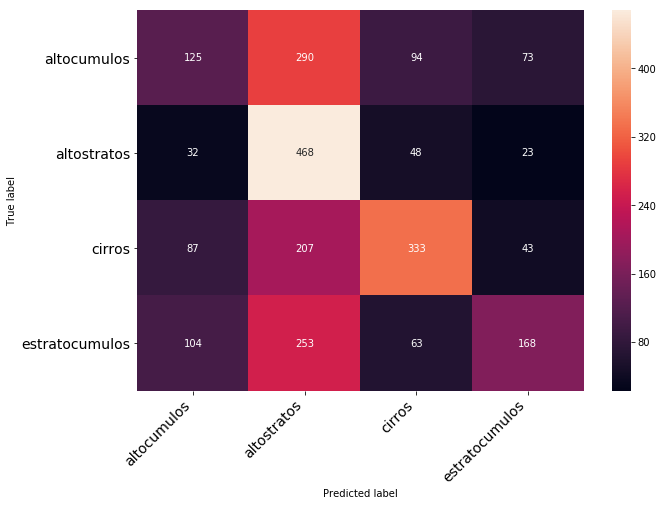

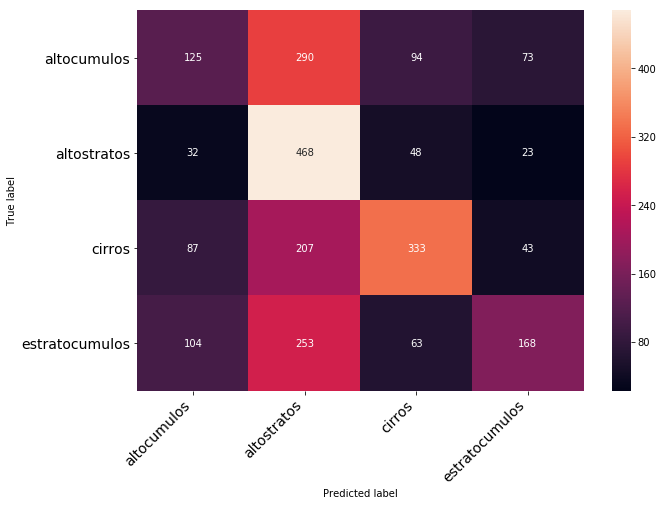

In [65]:
confusion = confusion_matrix(cloud_test_y, output_test)

print_confusion_matrix(confusion, cloud_lookup_table)

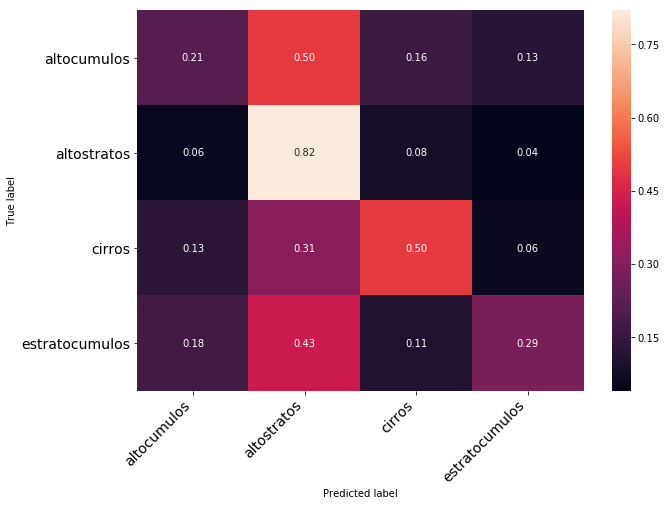

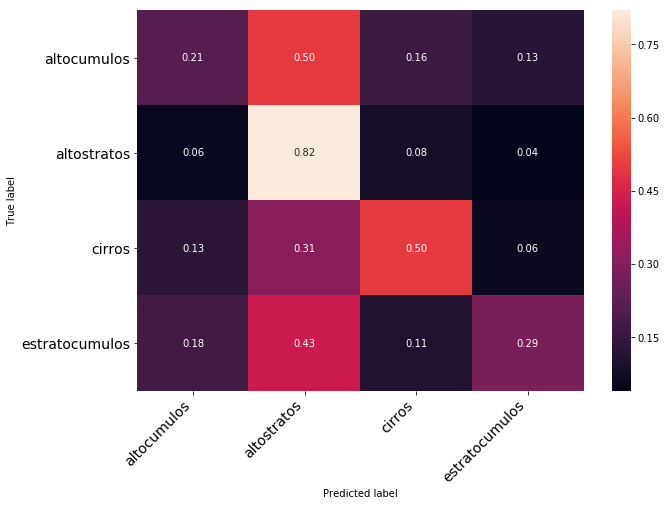

In [66]:
print_confusion_matrix(confusion, cloud_lookup_table, norm=True)

Probemos ahora con Batch normalization en las capas convolucionales.

In [67]:
net = LeNet(batch_norm=True).cuda()
output_test, success_history = train(500)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 0] Train loss: 1.4731550216674805 Test accuracy: 0.2961426793861468
[Epoch 1] Train loss: 1.419133186340332 Test accuracy: 0.294068851099129
[Epoch 2] Train loss: 1.4120198488235474 Test accuracy: 0.28328494400663623
[Epoch 3] Train loss: 1.4049237966537476 Test accuracy: 0.28452924097884696
[Epoch 4] Train loss: 1.3787131309509277 Test accuracy: 0.2807963500622149
[Epoch 5] Train loss: 1.393178105354309 Test accuracy: 0.28577353795105764
[Epoch 6] Train loss: 1.3966054916381836 Test accuracy: 0.29116549149730403
[Epoch 7] Train loss: 1.376232385635376 Test accuracy: 0.28369970966403985
[Epoch 8] Train loss: 1.3731029033660889 Test accuracy: 0.29738697635835754
[Epoch 9] Train loss: 1.4142223596572876 Test accuracy: 0.2953131480713397
[Epoch 10] Train loss: 1.4037350416183472 Test accuracy: 0.2948983824139361
[Epoch 11] Train loss: 1.3940950632095337 Test accuracy: 0.3542098714226462
[Epoch 12] Train loss: 1.4156851768493652 Test accuracy: 0.34135213604313563
[Epoch 13] Train lo

[Epoch 108] Train loss: 0.896857500076294 Test accuracy: 0.3832434674408959
[Epoch 109] Train loss: 0.8602129220962524 Test accuracy: 0.3936126088759851
[Epoch 110] Train loss: 0.9310383796691895 Test accuracy: 0.39236831190377436
[Epoch 111] Train loss: 0.8996596336364746 Test accuracy: 0.39236831190377436
[Epoch 112] Train loss: 0.9378325343132019 Test accuracy: 0.3931978432185815
[Epoch 113] Train loss: 0.8738789558410645 Test accuracy: 0.39485690584819577
[Epoch 114] Train loss: 0.7951631546020508 Test accuracy: 0.39527167150559933
[Epoch 115] Train loss: 0.8048564195632935 Test accuracy: 0.4035669846536707
[Epoch 116] Train loss: 0.7604533433914185 Test accuracy: 0.39153878058896724
[Epoch 117] Train loss: 0.8250420689582825 Test accuracy: 0.3919535462463708
[Epoch 118] Train loss: 0.8279817700386047 Test accuracy: 0.3927830775611779
[Epoch 119] Train loss: 0.8261785507202148 Test accuracy: 0.3990045624222314
[Epoch 120] Train loss: 0.8380679488182068 Test accuracy: 0.401493156366

[Epoch 214] Train loss: 0.5279821157455444 Test accuracy: 0.38987971795935294
[Epoch 215] Train loss: 0.4634717106819153 Test accuracy: 0.39485690584819577
[Epoch 216] Train loss: 0.5312265753746033 Test accuracy: 0.3873911240149316
[Epoch 217] Train loss: 0.4737142324447632 Test accuracy: 0.4110327664869349
[Epoch 218] Train loss: 0.5527779459953308 Test accuracy: 0.3936126088759851
[Epoch 219] Train loss: 0.5309586524963379 Test accuracy: 0.3873911240149316
[Epoch 220] Train loss: 0.6303837895393372 Test accuracy: 0.39402737453338865
[Epoch 221] Train loss: 0.4834652841091156 Test accuracy: 0.41269182911654917
[Epoch 222] Train loss: 0.5038955211639404 Test accuracy: 0.38241393612608876
[Epoch 223] Train loss: 0.49434930086135864 Test accuracy: 0.3857320613853173
[Epoch 224] Train loss: 0.49599629640579224 Test accuracy: 0.38365823309829944
[Epoch 225] Train loss: 0.4202357530593872 Test accuracy: 0.39402737453338865
[Epoch 226] Train loss: 0.4879116415977478 Test accuracy: 0.3915387

[Epoch 320] Train loss: 0.37390780448913574 Test accuracy: 0.38241393612608876
[Epoch 321] Train loss: 0.3784452974796295 Test accuracy: 0.38241393612608876
[Epoch 322] Train loss: 0.3127591907978058 Test accuracy: 0.3695562007465782
[Epoch 323] Train loss: 0.2748287320137024 Test accuracy: 0.38863542098714227
[Epoch 324] Train loss: 0.267169713973999 Test accuracy: 0.38241393612608876
[Epoch 325] Train loss: 0.33511751890182495 Test accuracy: 0.3849025300705102
[Epoch 326] Train loss: 0.25632116198539734 Test accuracy: 0.38158440481128164
[Epoch 327] Train loss: 0.35952430963516235 Test accuracy: 0.37909581086686023
[Epoch 328] Train loss: 0.3796926736831665 Test accuracy: 0.37743674823724593
[Epoch 329] Train loss: 0.29146474599838257 Test accuracy: 0.38365823309829944
[Epoch 330] Train loss: 0.4195045530796051 Test accuracy: 0.3873911240149316
[Epoch 331] Train loss: 0.3143686056137085 Test accuracy: 0.3819991704686852
[Epoch 332] Train loss: 0.25120800733566284 Test accuracy: 0.385

[Epoch 426] Train loss: 0.23950739204883575 Test accuracy: 0.38987971795935294
[Epoch 427] Train loss: 0.2753335237503052 Test accuracy: 0.3882206553297387
[Epoch 428] Train loss: 0.16945329308509827 Test accuracy: 0.3944421401907922
[Epoch 429] Train loss: 0.25571298599243164 Test accuracy: 0.38780588967233515
[Epoch 430] Train loss: 0.17306748032569885 Test accuracy: 0.3782662795520531
[Epoch 431] Train loss: 0.2463194876909256 Test accuracy: 0.3857320613853173
[Epoch 432] Train loss: 0.28081971406936646 Test accuracy: 0.3832434674408959
[Epoch 433] Train loss: 0.2301589399576187 Test accuracy: 0.3811696391538781
[Epoch 434] Train loss: 0.186414435505867 Test accuracy: 0.39485690584819577
[Epoch 435] Train loss: 0.19342204928398132 Test accuracy: 0.39153878058896724
[Epoch 436] Train loss: 0.2278868407011032 Test accuracy: 0.3844877644131066
[Epoch 437] Train loss: 0.19806315004825592 Test accuracy: 0.37992534218166735
[Epoch 438] Train loss: 0.16877669095993042 Test accuracy: 0.3990

La precisión conseguida añadiendo batch normalization es bastante mala, incluso cercana a la clasificación aleatoria, que para un problema de clasificación con 4 clases es de 25%.

Vamos a ver como son las matrices de confusión

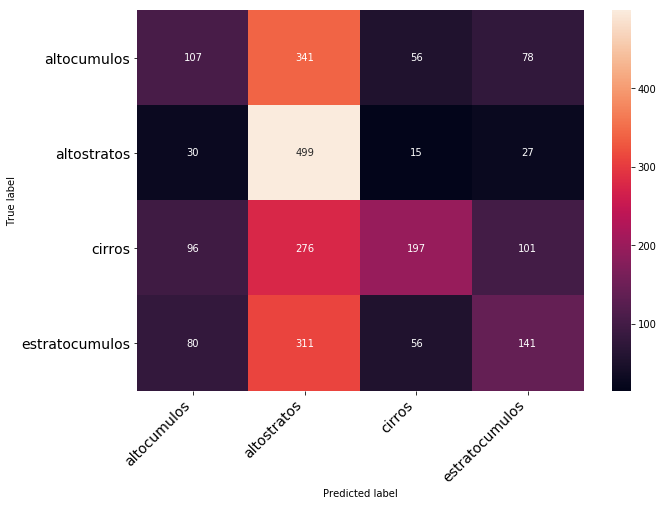

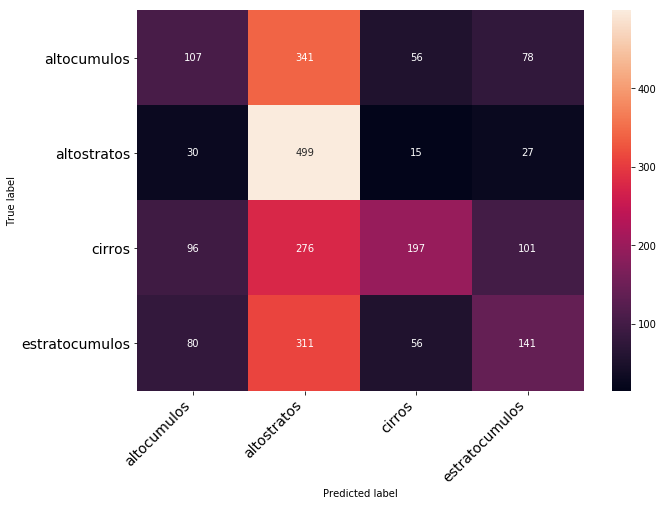

In [68]:
confusion = confusion_matrix(cloud_test_y, output_test)

print_confusion_matrix(confusion, cloud_lookup_table)

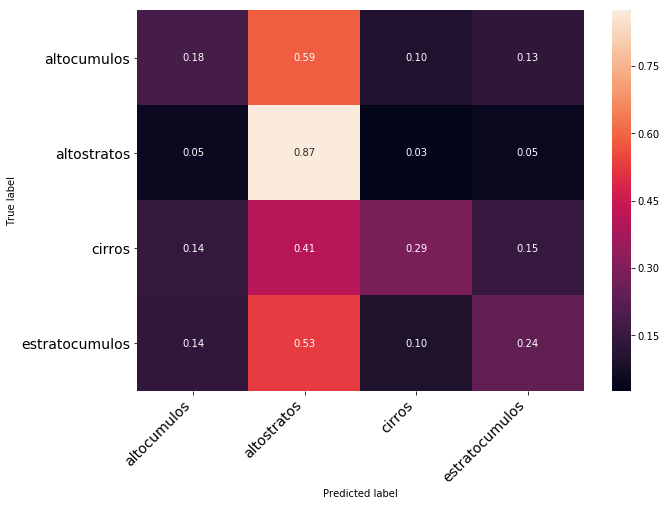

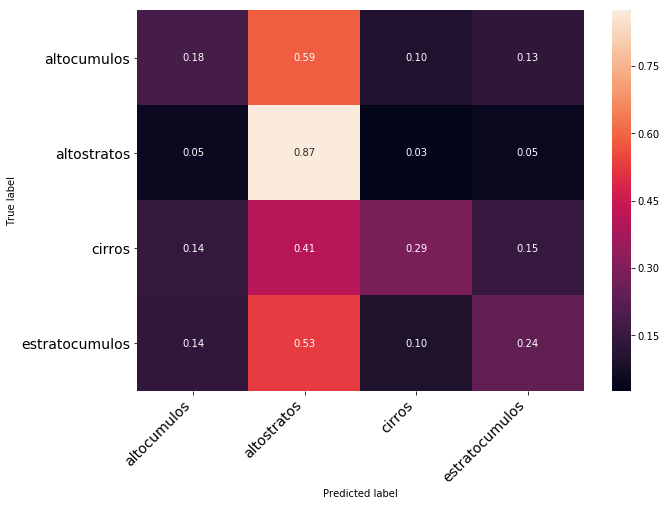

In [69]:
print_confusion_matrix(confusion, cloud_lookup_table, norm=True)

Por alguna razón, las nubes acaban siendo clasificadas como altostratos con una alta probabilidad.

La precision conseguida con LeNet-5 sin BN es mejor que la obtenida con una clasificación totalmente aleatoria. Pero no es muy buena, por lo que se va a probar con una red distinta.

In [70]:
class Net(nn.Module):
    
    def __init__(self, batch_norm=False):
        super(Net, self).__init__()
        self.batch_norm = batch_norm
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2) # 32x32
        self.bn1 = nn.BatchNorm2d(64)
        
        # Max Pooling (2,2) 16x16
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2) # 16x16
        self.bn2 = nn.BatchNorm2d(64)
        
        # Max Pooling (2,2) 8x8
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2) # 8x8
        self.bn3 = nn.BatchNorm2d(64)
        
        # Max Pooling (2,2) 4x4

        # Fully connected
        self.fc1 = nn.Linear(64 * 4 * 4, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, len(cloud_lookup_table))
        
        self.drop = nn.Dropout(0.2)
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)       
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        b_size = x.size(0)
        
        # 1 Layer
        x = self.drop(self.conv1(x))
        if self.batch_norm:
            x = self.bn1(x)
        x = F.max_pool2d(F.relu(x), (2,2))
        
        # 2 Layer
        x = self.drop(self.conv2(x))
        if self.batch_norm:
            x = self.bn2(x)
        x = F.max_pool2d(F.relu(x), (2,2))
        
        # 3 Layer
        x = self.drop(self.conv3(x))
        if self.batch_norm:
            x = self.bn3(x)
        x = F.max_pool2d(F.relu(x), (2,2))
        
        x = x.view(b_size, -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x)
        
net = Net().cuda()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=4, bias=True)
  (drop): Dropout(p=0.2)
)


In [71]:
output_test, success_history = train(600)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 0] Train loss: 1.4121342897415161 Test accuracy: 0.3052675238490253
[Epoch 1] Train loss: 1.4092618227005005 Test accuracy: 0.2994608046453754
[Epoch 2] Train loss: 1.392064094543457 Test accuracy: 0.30817088345085025
[Epoch 3] Train loss: 1.3767902851104736 Test accuracy: 0.3069265864786396
[Epoch 4] Train loss: 1.3692008256912231 Test accuracy: 0.3114890087100788
[Epoch 5] Train loss: 1.3335678577423096 Test accuracy: 0.3450850269597677
[Epoch 6] Train loss: 1.3337349891662598 Test accuracy: 0.32061385317295726
[Epoch 7] Train loss: 1.3026262521743774 Test accuracy: 0.32766486934881794
[Epoch 8] Train loss: 1.2854421138763428 Test accuracy: 0.36084612194110327
[Epoch 9] Train loss: 1.293984293937683 Test accuracy: 0.3678971381169639
[Epoch 10] Train loss: 1.2355263233184814 Test accuracy: 0.40024885939444216
[Epoch 11] Train loss: 1.1958805322647095 Test accuracy: 0.4160099543757777
[Epoch 12] Train loss: 1.211285948753357 Test accuracy: 0.42389050186644545
[Epoch 13] Train lo

[Epoch 108] Train loss: 0.33316770195961 Test accuracy: 0.5072583990045624
[Epoch 109] Train loss: 0.3104960322380066 Test accuracy: 0.5072583990045624
[Epoch 110] Train loss: 0.3713151514530182 Test accuracy: 0.501866445458316
[Epoch 111] Train loss: 0.3396354913711548 Test accuracy: 0.5002073828287018
[Epoch 112] Train loss: 0.3714330494403839 Test accuracy: 0.492326835338034
[Epoch 113] Train loss: 0.30653297901153564 Test accuracy: 0.5006221484861053
[Epoch 114] Train loss: 0.29521822929382324 Test accuracy: 0.5022812111157197
[Epoch 115] Train loss: 0.3695702850818634 Test accuracy: 0.4997926171712982
[Epoch 116] Train loss: 0.24298729002475739 Test accuracy: 0.4939858979676483
[Epoch 117] Train loss: 0.2648901641368866 Test accuracy: 0.5010369141435089
[Epoch 118] Train loss: 0.42774099111557007 Test accuracy: 0.49813355454168395
[Epoch 119] Train loss: 0.31729069352149963 Test accuracy: 0.5118208212360017
[Epoch 120] Train loss: 0.2965058386325836 Test accuracy: 0.49979261717129

[Epoch 214] Train loss: 0.15711502730846405 Test accuracy: 0.48444628784736626
[Epoch 215] Train loss: 0.12150494754314423 Test accuracy: 0.49025300705101615
[Epoch 216] Train loss: 0.09038908034563065 Test accuracy: 0.47822480298631276
[Epoch 217] Train loss: 0.10707095265388489 Test accuracy: 0.48278722521775197
[Epoch 218] Train loss: 0.08550302684307098 Test accuracy: 0.48029863127333056
[Epoch 219] Train loss: 0.11847517639398575 Test accuracy: 0.4848610535047698
[Epoch 220] Train loss: 0.06475381553173065 Test accuracy: 0.4890087100788055
[Epoch 221] Train loss: 0.12671710550785065 Test accuracy: 0.48029863127333056
[Epoch 222] Train loss: 0.18498024344444275 Test accuracy: 0.4873496474491912
[Epoch 223] Train loss: 0.5006148815155029 Test accuracy: 0.4836167565325591
[Epoch 224] Train loss: 0.08755433559417725 Test accuracy: 0.47946909995852344
[Epoch 225] Train loss: 0.06280232965946198 Test accuracy: 0.49191206968063045
[Epoch 226] Train loss: 0.04853091388940811 Test accuracy

[Epoch 319] Train loss: 0.011767320334911346 Test accuracy: 0.4968892575694733
[Epoch 320] Train loss: 0.053287215530872345 Test accuracy: 0.4939858979676483
[Epoch 321] Train loss: 0.030182912945747375 Test accuracy: 0.4948154292824554
[Epoch 322] Train loss: 0.05175923556089401 Test accuracy: 0.4935711323102447
[Epoch 323] Train loss: 0.020226921886205673 Test accuracy: 0.4997926171712982
[Epoch 324] Train loss: 0.01720396615564823 Test accuracy: 0.4935711323102447
[Epoch 325] Train loss: 0.015686675906181335 Test accuracy: 0.501866445458316
[Epoch 326] Train loss: 0.04584430158138275 Test accuracy: 0.4968892575694733
[Epoch 327] Train loss: 0.004957251250743866 Test accuracy: 0.49730402322687683
[Epoch 328] Train loss: 0.004590682685375214 Test accuracy: 0.49813355454168395
[Epoch 329] Train loss: 0.08530823886394501 Test accuracy: 0.49191206968063045
[Epoch 330] Train loss: 0.004474960267543793 Test accuracy: 0.5006221484861053
[Epoch 331] Train loss: 0.009720832109451294 Test accu

[Epoch 423] Train loss: 0.02547868713736534 Test accuracy: 0.49274160099543757
[Epoch 424] Train loss: 0.024091575294733047 Test accuracy: 0.4960597262546661
[Epoch 425] Train loss: 0.013971000909805298 Test accuracy: 0.4873496474491912
[Epoch 426] Train loss: 0.09947530925273895 Test accuracy: 0.4960597262546661
[Epoch 427] Train loss: 0.0007803142070770264 Test accuracy: 0.492326835338034
[Epoch 428] Train loss: 0.019236460328102112 Test accuracy: 0.4873496474491912
[Epoch 429] Train loss: 0.0009039938449859619 Test accuracy: 0.48278722521775197
[Epoch 430] Train loss: 0.002739138901233673 Test accuracy: 0.49025300705101615
[Epoch 431] Train loss: 0.0004054158926010132 Test accuracy: 0.4914973040232269
[Epoch 432] Train loss: 0.001518934965133667 Test accuracy: 0.4885939444214019
[Epoch 433] Train loss: 0.04240039363503456 Test accuracy: 0.49274160099543757
[Epoch 434] Train loss: 0.008989386260509491 Test accuracy: 0.4931563666528411
[Epoch 435] Train loss: 0.0038677603006362915 Tes

[Epoch 526] Train loss: 0.00025209784507751465 Test accuracy: 0.4977187888842804
[Epoch 527] Train loss: 0.0022538751363754272 Test accuracy: 0.4885939444214019
[Epoch 528] Train loss: 0.012905940413475037 Test accuracy: 0.4914973040232269
[Epoch 529] Train loss: 0.004379242658615112 Test accuracy: 0.4968892575694733
[Epoch 530] Train loss: 0.009901829063892365 Test accuracy: 0.49191206968063045
[Epoch 531] Train loss: 0.006339237093925476 Test accuracy: 0.4931563666528411
[Epoch 532] Train loss: 0.0011617094278335571 Test accuracy: 0.48942347573620903
[Epoch 533] Train loss: 0.0012978017330169678 Test accuracy: 0.4939858979676483
[Epoch 534] Train loss: 0.028547458350658417 Test accuracy: 0.48942347573620903
[Epoch 535] Train loss: 0.03223014995455742 Test accuracy: 0.48444628784736626
[Epoch 536] Train loss: 0.00010687112808227539 Test accuracy: 0.49730402322687683
[Epoch 537] Train loss: 0.001466318964958191 Test accuracy: 0.49647449191206966
[Epoch 538] Train loss: 0.00284133851528

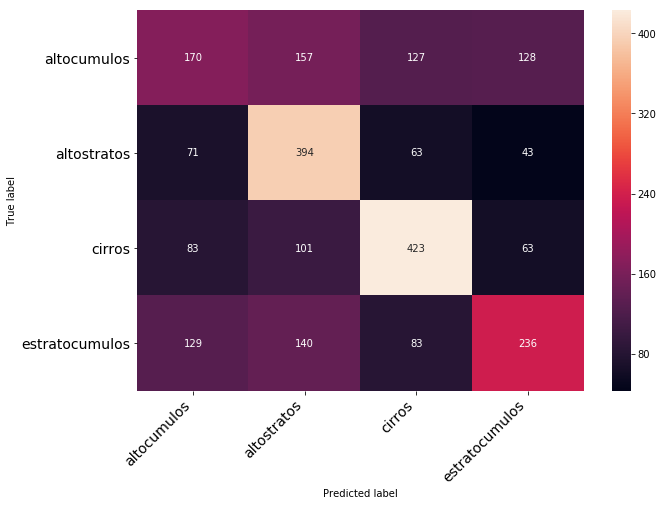

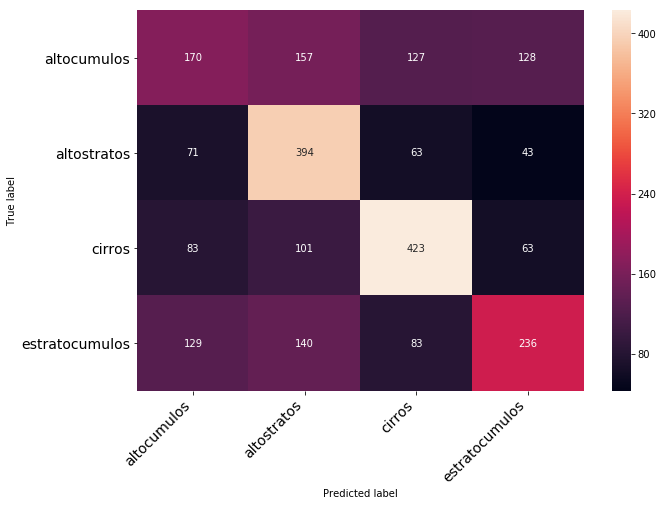

In [72]:
confusion = confusion_matrix(cloud_test_y, output_test)
print_confusion_matrix(confusion, cloud_lookup_table)

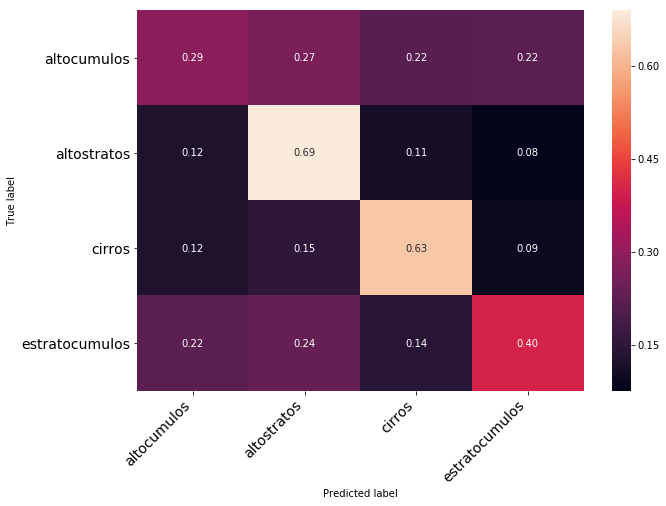

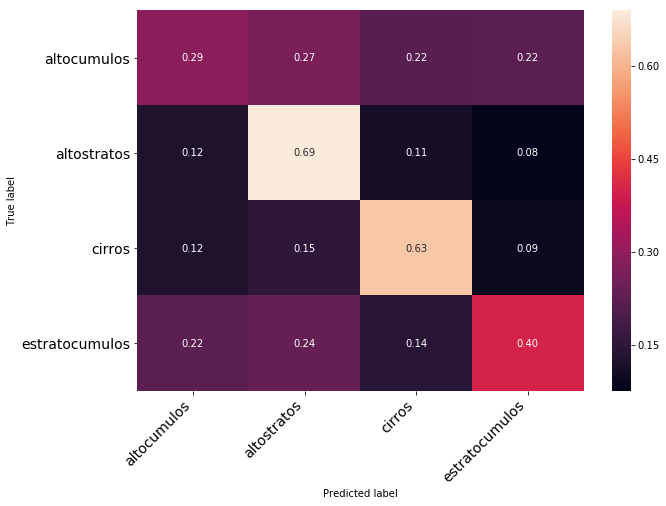

In [73]:
print_confusion_matrix(confusion, cloud_lookup_table, norm=True)

Probemos como se comporta esta ultima red utilizando Batch Normalization

In [74]:
net = Net(batch_norm=True).cuda()
output_test, success_history = train(500)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch 0] Train loss: 1.4804103374481201 Test accuracy: 0.26047283284944006
[Epoch 1] Train loss: 1.5045727491378784 Test accuracy: 0.3090004147656574
[Epoch 2] Train loss: 1.4836914539337158 Test accuracy: 0.37121526337619243
[Epoch 3] Train loss: 1.4348523616790771 Test accuracy: 0.3616756532559104
[Epoch 4] Train loss: 1.4007400274276733 Test accuracy: 0.37743674823724593
[Epoch 5] Train loss: 1.3901808261871338 Test accuracy: 0.3828287017834923
[Epoch 6] Train loss: 1.386397123336792 Test accuracy: 0.40522604728328493
[Epoch 7] Train loss: 1.3847229480743408 Test accuracy: 0.36540854417254254
[Epoch 8] Train loss: 1.3881388902664185 Test accuracy: 0.37909581086686023
[Epoch 9] Train loss: 1.3832147121429443 Test accuracy: 0.3795105765242638
[Epoch 10] Train loss: 1.335829734802246 Test accuracy: 0.3766072169224388
[Epoch 11] Train loss: 1.2866976261138916 Test accuracy: 0.3749481542928246
[Epoch 12] Train loss: 1.2527204751968384 Test accuracy: 0.39776026545002074
[Epoch 13] Train 

[Epoch 107] Train loss: 0.08293235301971436 Test accuracy: 0.427208627125674
[Epoch 108] Train loss: 0.04410843923687935 Test accuracy: 0.4197428452924098
[Epoch 109] Train loss: 0.0977056473493576 Test accuracy: 0.41642472003318126
[Epoch 110] Train loss: 0.09757043421268463 Test accuracy: 0.42803815844048115
[Epoch 111] Train loss: 0.07991000264883041 Test accuracy: 0.4209871422646205
[Epoch 112] Train loss: 0.08666051179170609 Test accuracy: 0.40647034425549566
[Epoch 113] Train loss: 0.14268052577972412 Test accuracy: 0.43011198672749895
[Epoch 114] Train loss: 0.09353955090045929 Test accuracy: 0.424305267523849
[Epoch 115] Train loss: 0.06384623050689697 Test accuracy: 0.4010783907092493
[Epoch 116] Train loss: 0.1314919888973236 Test accuracy: 0.42389050186644545
[Epoch 117] Train loss: 0.0536731518805027 Test accuracy: 0.42762339278307754
[Epoch 118] Train loss: 0.04853656142950058 Test accuracy: 0.42762339278307754
[Epoch 119] Train loss: 0.1320776641368866 Test accuracy: 0.40

[Epoch 211] Train loss: 0.005103960633277893 Test accuracy: 0.3732890916632103
[Epoch 212] Train loss: 0.005722060799598694 Test accuracy: 0.38158440481128164
[Epoch 213] Train loss: 0.002730719745159149 Test accuracy: 0.3927830775611779
[Epoch 214] Train loss: 0.00465722382068634 Test accuracy: 0.3795105765242638
[Epoch 215] Train loss: 0.010344915091991425 Test accuracy: 0.37080049771878887
[Epoch 216] Train loss: 0.00505741685628891 Test accuracy: 0.39527167150559933
[Epoch 217] Train loss: 0.007797211408615112 Test accuracy: 0.38531729572791373
[Epoch 218] Train loss: 0.06302258372306824 Test accuracy: 0.38158440481128164
[Epoch 219] Train loss: 0.007816977798938751 Test accuracy: 0.3969307341352136
[Epoch 220] Train loss: 0.03872772306203842 Test accuracy: 0.41393612608875985
[Epoch 221] Train loss: 0.005426056683063507 Test accuracy: 0.4168394856905848
[Epoch 222] Train loss: 0.0033822357654571533 Test accuracy: 0.42264620489423477
[Epoch 223] Train loss: 0.06449200958013535 Test

[Epoch 314] Train loss: 0.004155047237873077 Test accuracy: 0.3990045624222314
[Epoch 315] Train loss: 0.03807838261127472 Test accuracy: 0.41393612608875985
[Epoch 316] Train loss: 0.004465796053409576 Test accuracy: 0.4168394856905848
[Epoch 317] Train loss: 0.009481631219387054 Test accuracy: 0.4234757362090419
[Epoch 318] Train loss: 0.013529099524021149 Test accuracy: 0.40771464122770634
[Epoch 319] Train loss: 0.25041505694389343 Test accuracy: 0.4097884695147242
[Epoch 320] Train loss: 0.0022169947624206543 Test accuracy: 0.38987971795935294
[Epoch 321] Train loss: 0.010044820606708527 Test accuracy: 0.41476565740356697
[Epoch 322] Train loss: 0.0047772228717803955 Test accuracy: 0.34467026130236417
[Epoch 323] Train loss: 0.004050485789775848 Test accuracy: 0.3678971381169639
[Epoch 324] Train loss: 0.010262034833431244 Test accuracy: 0.38987971795935294
[Epoch 325] Train loss: 0.004638783633708954 Test accuracy: 0.42181667357942765
[Epoch 326] Train loss: 0.018285304307937622 

[Epoch 417] Train loss: 0.00017473101615905762 Test accuracy: 0.3998340937370386
[Epoch 418] Train loss: 0.00023120641708374023 Test accuracy: 0.4081294068851099
[Epoch 419] Train loss: 0.00041083991527557373 Test accuracy: 0.4019079220240564
[Epoch 420] Train loss: 0.0001547783613204956 Test accuracy: 0.4060555785980921
[Epoch 421] Train loss: 0.00015941262245178223 Test accuracy: 0.3936126088759851
[Epoch 422] Train loss: 0.00011493265628814697 Test accuracy: 0.39776026545002074
[Epoch 423] Train loss: 0.055342286825180054 Test accuracy: 0.39402737453338865
[Epoch 424] Train loss: 0.0006978809833526611 Test accuracy: 0.39029448361675656
[Epoch 425] Train loss: 0.003581702709197998 Test accuracy: 0.3844877644131066
[Epoch 426] Train loss: 0.014079101383686066 Test accuracy: 0.3649937785151389
[Epoch 427] Train loss: 0.0005504190921783447 Test accuracy: 0.3981750311074243
[Epoch 428] Train loss: 0.0009846538305282593 Test accuracy: 0.37121526337619243
[Epoch 429] Train loss: 0.00021323

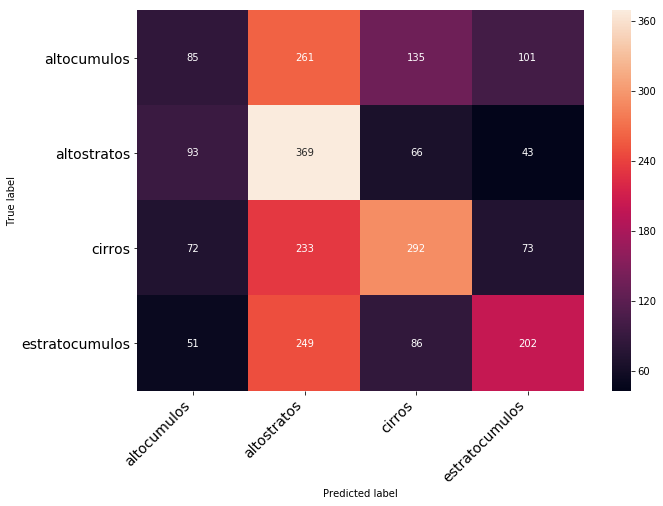

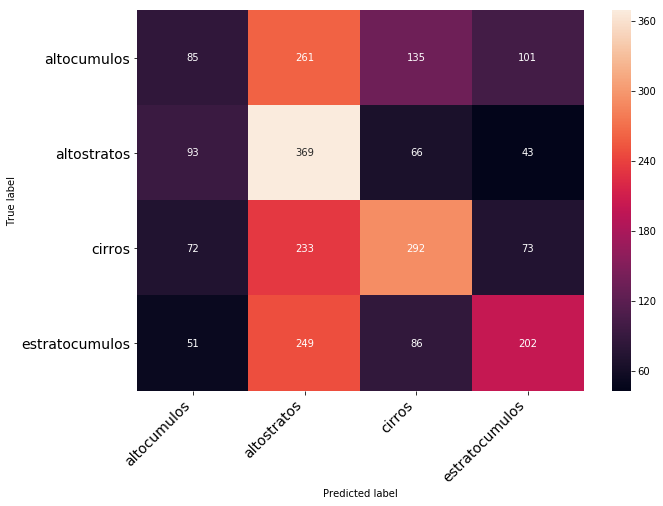

In [75]:
confusion = confusion_matrix(cloud_test_y, output_test)
print_confusion_matrix(confusion, cloud_lookup_table)

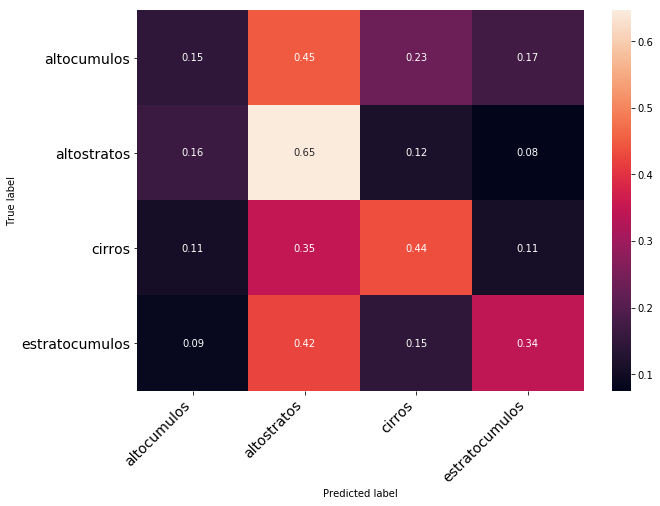

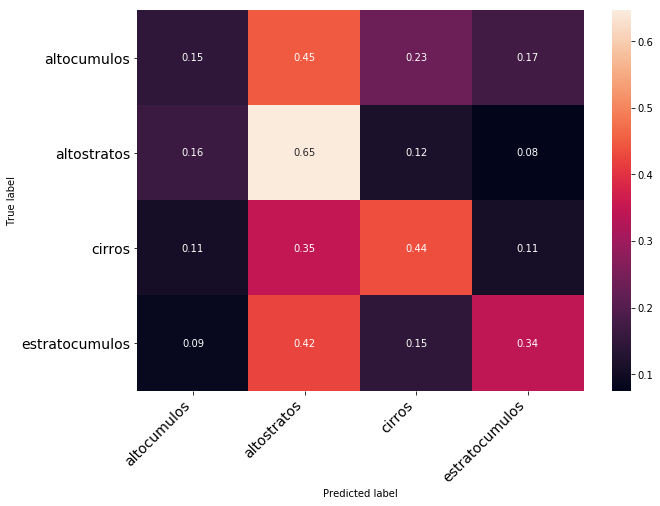

In [76]:
print_confusion_matrix(confusion, cloud_lookup_table, norm=True)

 Esta ultima red devuelve mejores resultados que la anterior. Pero igual que en la red anterior, al utilizar BN la precisión de la misma acaba bajando.